In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


# Polynmial regression model

In [3]:
class PolynomialRegression:
     
    def __init__(self, degree, learning_rate, iterations):
        self.degree = degree
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.W = None
        self.mean = None
        self.std = None

    # Function to transform X into polynomial features
    def transform(self, X):
        # Start with the bias term (X^0 = 1)
        X_transform = np.ones((X.shape[0], 1))  # Shape: (n_samples, 1)
        
        # Loop through degrees from 1 to the specified degree
        for j in range(1, self.degree + 1):
            for feature in range(X.shape[1]):  # Loop through all features (columns) in X
                X_pow = np.power(X[:, feature], j).reshape(-1, 1)  # Raise each feature to the power j
                X_transform = np.hstack((X_transform, X_pow))  # Stack the new column horizontally
            
        return X_transform


    # Function to normalize the features (save mean and std for normalization)
    def normalize(self, X):
        if self.mean is None or self.std is None:
            self.mean = np.mean(X[:, 1:], axis=0)  # Mean excluding the bias term
            self.std = np.std(X[:, 1:], axis=0)    # Standard deviation excluding the bias term
        X[:, 1:] = (X[:, 1:] - self.mean) / self.std
        return X

    # Model training using gradient descent
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.n = self.X.shape

        # Transform X into polynomial features
        X_transform = self.transform(self.X)

        # Normalize the transformed features
        X_normalize = self.normalize(X_transform)

        # Initialize weights - ensure it is a column by using reshape ()
        self.W = np.zeros(X_normalize.shape[1]).reshape(-1,1)

        print(f'model training: x_normalize shape:{X_normalize.shape}\nWeights shape: {self.W.shape}')
        # Gradient descent learning
        for i in range(self.iterations):
            h = self.predict(self.X)

            error = h - self.Y

            if i == 0:
                print(f'h shape:{h.shape} Self.y shape: {self.Y.shape} Error vector shape: {error.shape}')
            # Update weights
            self.W = self.W - self.learning_rate * (1 / self.m) * np.dot(X_normalize.T, error)

            if i == 0:
                print(f'weight shape:{self.W.shape}')

        return self

    # Predict function using the learned weights
    def predict(self, X):
        # Transform and normalize X for prediction
        X_transform = self.transform(X)
        X_normalize = self.normalize(X_transform)

        #ensure output is a column vector
        return np.dot(X_normalize, self.W).reshape(-1,1)
    

# Data loading and unifeature lag engineering

        Time     Open     High      Low    Close  Volume
0 2008-08-01  1.55575  1.55886  1.55142  1.55609  755330
1 2008-08-03  1.55638  1.55790  1.55586  1.55658   76728
2 2008-08-04  1.55662  1.56306  1.55526  1.55638  858293
3 2008-08-05  1.55624  1.55646  1.54442  1.54640  858740
4 2008-08-06  1.54650  1.55167  1.53956  1.54195  850798
<class 'numpy.ndarray'>
model training: x_normalize shape:(4002, 31)
Weights shape: (31, 1)
h shape:(4002, 1) Self.y shape: (4002, 1) Error vector shape: (4002, 1)
weight shape:(31, 1)


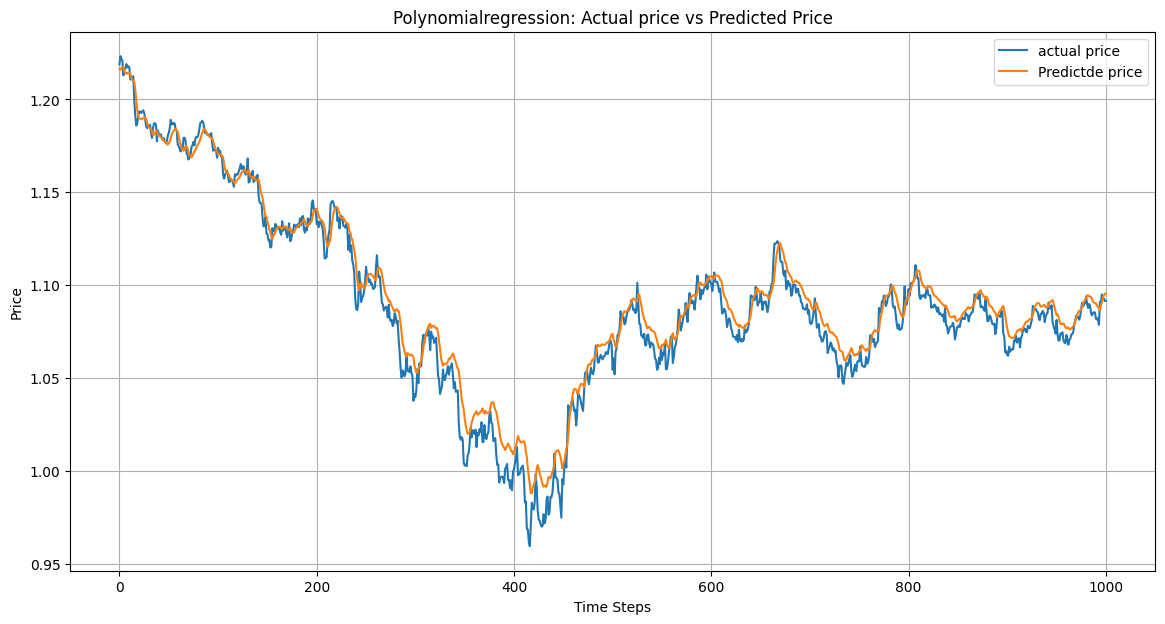

In [9]:
# Data loading
def data_loader(filepath):
    data = pd.read_csv(filepath)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    return data

#select one feature
def featureEngineering(data, n_past=1):
    X = []
    Y= []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i, -2].values)  # Select n_past number of rows for the closing price
        Y.append(data.iloc[i, -2])  # The target value - closing

    feature_columns = [f'n_{i}' for i in range(1, n_past+1)]
    X_df = pd.DataFrame(X, columns=feature_columns)
    Y_df = pd.DataFrame(Y, columns=['response'])

    data = pd.concat([X_df, Y_df], axis=1)

    return data, X_df,Y_df

filepath = './Data/EURUSD_D1.csv' 
datasetX = data_loader(filepath)

print(datasetX.head())

n_past =10 

laggedDataset, f_lag, response = featureEngineering(datasetX,n_past)

# train , test split
x_train, x_test, y_train, y_test = train_test_split(f_lag, response, test_size=0.2,random_state=12, shuffle=False)

print(type(x_train.values))

#create instance of model
degree = 3  # Quadratic polynomial
learning_rate = 0.01
iterations = 1000

modelPolReg = PolynomialRegression(degree, learning_rate, iterations)
modelPolReg.fit(x_train.values, y_train.values)

#make predictions
y_pred = modelPolReg.predict(x_test.values)

#convert to 1D /numpyarray for plotting
y_test = y_test.to_numpy()
y_pred = y_pred.flatten()

plt.figure(figsize=(14, 7))
plt.plot(y_test, label ='actual price')
plt.plot(y_pred, label='Predictde price')
plt.title('Polynomialregression: Actual price vs Predicted Price')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Polynomial regression forcast N timesteps

/tmp/ipykernel_122262/965301853.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_last_point[-1] = y_predict  # Add the new prediction at the end


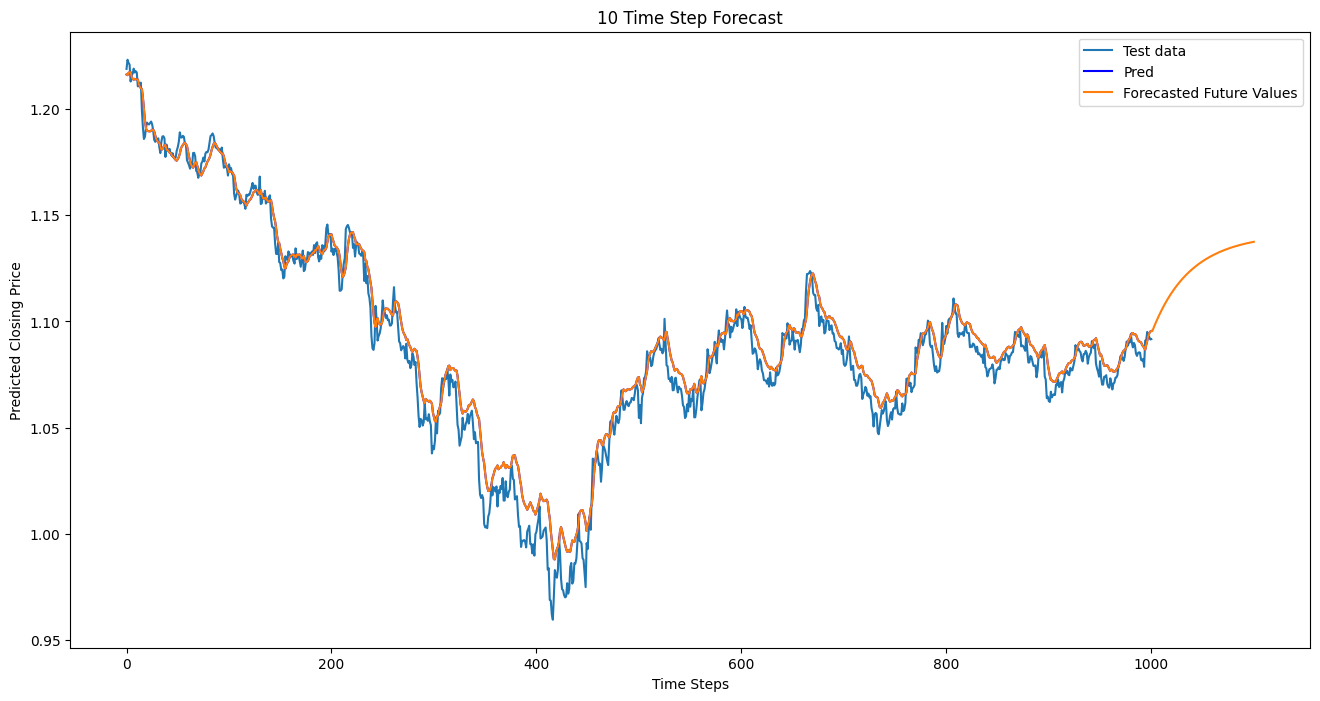

In [10]:
test_last_point =[]
test_last_point = x_test.iloc[-1].to_numpy()  # Use the last row of X_test (X previous time steps) - if using STD scalar , comment out
forecastedRate = []

n_future = 100 

for i in range(n_future):
    # Reshape test_last_point into a 2D array before passing to predict
    test_last_point_reshaped = test_last_point.reshape(1, -1)
    
    y_predict = modelPolReg.predict(test_last_point_reshaped)  # Predict next time step

    forecastedRate.append(y_predict.flatten())  # Flatten to 1D and store prediction

    # Shift the values left and append the predicted value at the end
    test_last_point = np.roll(test_last_point, -1)  # Shift values left
    test_last_point[-1] = y_predict  # Add the new prediction at the end

# Concatenate predictions with the forecasted future values
forecastedRate = np.array(forecastedRate).flatten()  # Flatten the list of predictions
y_pred_combined = np.concatenate([y_pred, forecastedRate])

# Plot the forecasted results
plt.figure(figsize=(16, 8))
plt.plot(y_test,label='Test data')
plt.plot(y_pred, label='Pred', color='blue')
plt.plot(y_pred_combined, label='Forecasted Future Values')
plt.xlabel('Time Steps')
plt.ylabel('Predicted Closing Price')
plt.title('10 Time Step Forecast')
plt.legend()
plt.show()

# Multivariate forecasting

In [3]:
# Feature Engineering
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

class PolynomialRegression2:
     
    def __init__(self, degree, learning_rate, iterations):
        self.degree = degree
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.W = None
        self.mean = None
        self.std = None

    # Function to transform X into polynomial features
    def transform(self, X):
        # Start with the bias term (X^0 = 1)
        X_transform = np.ones((X.shape[0], 1))  # Shape: (n_samples, 1)
        
        # Loop through degrees from 1 to the specified degree
        for j in range(1, self.degree + 1):
            for feature in range(X.shape[1]):  # Loop through all features (columns) in X
                X_pow = np.power(X[:, feature], j).reshape(-1, 1)  # Raise each feature to the power j
                X_transform = np.hstack((X_transform, X_pow))  # Stack the new column horizontally
            
        return X_transform


    # Function to normalize the features (save mean and std for normalization)
    def normalize(self, X):
        if self.mean is None or self.std is None:
            self.mean = np.mean(X[:, 1:], axis=0)  # Mean excluding the bias term
            self.std = np.std(X[:, 1:], axis=0)    # Standard deviation excluding the bias term
        X[:, 1:] = (X[:, 1:] - self.mean) / self.std
        return X

    # Model training using gradient descent
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.m, self.n = self.X.shape

        # Transform X into polynomial features
        X_transform = self.transform(self.X)

        # Normalize the transformed features
        X_normalize = self.normalize(X_transform)

        # Initialize weights - ensure it is a column by using reshape ()
        self.W = np.zeros(X_normalize.shape[1]).reshape(-1,1)

        print(f'model training: x_normalize shape:{X_normalize.shape}\nWeights shape: {self.W.shape}')
        # Gradient descent learning
        for i in range(self.iterations):
            h = self.predict(self.X)

            error = h - self.Y.reshape(-1,1)

            if i == 0:
                print(f'h shape:{h.shape} Self.y shape: {self.Y.shape} Error vector shape: {error.shape}')
            # Update weights
            self.W = self.W - self.learning_rate * (1 / self.m) * np.dot(X_normalize.T, error)

            if i == 0:
                print(f'weight shape:{self.W.shape}')

        return self

    # Predict function using the learned weights
    def predict(self, X):
        # Transform and normalize X for prediction
        X_transform = self.transform(X)
        X_normalize = self.normalize(X_transform)

        #ensure output is a column vector
        return np.dot(X_normalize, self.W).reshape(-1,1)
    

def multivariateFeatureEngineering(filepath):
    data = pd.read_csv(filepath)

    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')
    
    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    #Trend following Indicators:

    #SMA - identofy long term trend
    data['50_sma'] = data['Close'].rolling(window=50).mean() 
    data['200_sma'] = data['Close'].rolling(window=200).mean() 

    #EMA - trend analysis: more weight applied to recent points
    data['50_ema'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['100_ema'] = data['Close'].ewm(span=100, adjust=False).mean()

    #MACD
    data['12_ema'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['26_ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD_line'] = data['12_ema']-data['26_ema'] # calculate the MACD line
    data['Signal_line'] = data['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    data['MACD_histogram'] = data['MACD_line'] - data['Signal_line']

    #ADX
    # Calculate ADX using TA-Lib (14-period by default)
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)

    #Momentum indicators:

    #RSI - 14-period
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
    
    #Stochastic Oscillator
    data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Close'], 
                                                fastk_period=14, slowk_period=3, slowd_period=3)

    #Williams %R - Default period is 14
    data['Williams_R'] = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)

    #Volatility indicators#:

    #Bollinger Bands - Default period is 20 for moving average and standard deviation (can be adjusted)
    data['upper_band'], data['middle_band'], data['lower_band'] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    #ATR -Default period for ATR is 14
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)

   
    data = data.dropna() # drop rows that have NA

    return data

filepath= './Data/EURUSD_D1.csv'
multivariateDataset = multivariateFeatureEngineering(filepath) #Include addtional features outside of OHLCV
#Drop time column , reset index
multivariateDataset = multivariateDataset.drop(columns=['Time']).reset_index(drop=True)

# reshape an input data into n_samples x timesteps x n_features.
# NOTE: data should be standardized

def multivariateFeatureLag(data, n_past, n_future, target_column=1):
    features = []
    response = []

    for i in range(n_past, len(data) - n_future + 1):
        # Extract the past n_past time steps as features
        features.append(data.iloc[i - n_past:i, :].values)  # Take all columns as features

        # Extract the target value (Close price in this case)
        response.append(data.iloc[i + n_future - 1, target_column])  # Extract the target column for response

    # Move the conversion to NumPy arrays outside the loop
    features = np.array(features)  # Convert to NumPy array after the loop finishes
    response = np.array(response)  # Convert to NumPy array after the loop finishes

    features_flat = features.reshape(features.shape[0], -1) # make shape 2d

    return features_flat, response


n_past = 5 
n_future = 1
target_col = -1
cols = [col for col in multivariateDataset.columns if col!='Close'] +['Close'] #shift Close to end
multivariateDataset =multivariateDataset[cols]

#select subset
selected_features = ['Open','High','ADX','stoch_k','ATR','RSI','Close']
# selected_features = ['RSI','Close'] #Mometum indicators improve permonance

multivariateDataset = multivariateDataset[selected_features]
print(multivariateDataset.head())

# multivariateDataset = multivariateDataset.to_numpy()

m_X, m_Y = multivariateFeatureLag(multivariateDataset,n_past, n_future, target_col )

feature_columns = [f'feature_{i}' for i in range(m_X.shape[1])]  # Name columns as 'feature_0', 'feature_1', ...
df_features = pd.DataFrame(m_X, columns=feature_columns)
df_response = pd.DataFrame(m_Y, columns=['Target'])

print(df_features.head())

# data split 
m_x_train, m_x_test, m_train_y, m_test_y = train_test_split(m_X, m_Y, test_size=0.2, random_state=12, shuffle=False)

#Feature scaling - weigh each feature equally
scaler = StandardScaler()
m_x_train = scaler.fit_transform(m_x_train)
m_x_test = scaler.transform(m_x_test)


#create instance of model
degree = 3  #  polynomial degree
learning_rate = 0.01
iterations = 1000

m_model = PolynomialRegression2(degree, learning_rate, iterations)
m_model.fit(m_x_train, m_train_y)

#test set
m_predict = m_model.predict(m_x_test)

plt.figure(figsize=(16, 8))
plt.plot(m_test_y, label= 'Actual Price')
plt.plot(m_predict, label ='Predicted')
plt.legend()
plt.show()





      Open     High        ADX    stoch_k       ATR        RSI    Close
0  1.36200  1.36740  26.500387  90.697924  0.019604  72.838761  1.36265
1  1.36265  1.37360  27.937534  89.342702  0.019997  72.357480  1.36175
2  1.36175  1.36780  28.803357  86.299069  0.020336  65.309168  1.34810
3  1.34810  1.36465  29.497963  84.546555  0.020516  67.623206  1.35740
4  1.35740  1.36385  30.142955  81.674148  0.020083  65.254212  1.35270
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    1.36200    1.36740  26.500387  90.697924   0.019604  72.838761   
1    1.36265    1.37360  27.937534  89.342702   0.019997  72.357480   
2    1.36175    1.36780  28.803357  86.299069   0.020336  65.309168   
3    1.34810    1.36465  29.497963  84.546555   0.020516  67.623206   
4    1.35740    1.36385  30.142955  81.674148   0.020083  65.254212   

   feature_6  feature_7  feature_8  feature_9  ...  feature_25  feature_26  \
0    1.36265    1.36265    1.37360  27.937534  ...    0.020516 

KeyboardInterrupt: 

In [4]:
# multi output polynomial regression:


# class PolynomialRegressionMultiOutput:
     
#     def __init__(self, degree, learning_rate, iterations):
#         self.degree = degree
#         self.learning_rate = learning_rate
#         self.iterations = iterations
#         self.W = None
#         self.mean = None
#         self.std = None

#     # Function to transform X into polynomial features
#     def transform(self, X):
#         # Start with the bias term (X^0 = 1)
#         X_transform = np.ones((X.shape[0], 1))  # Shape: (n_samples, 1)
        
#         # Loop through degrees from 1 to the specified degree
#         for j in range(1, self.degree + 1):
#             for feature in range(X.shape[1]):  # Loop through all features (columns) in X
#                 X_pow = np.power(X[:, feature], j).reshape(-1, 1)  # Raise each feature to the power j
#                 X_transform = np.hstack((X_transform, X_pow))  # Stack the new column horizontally
            
#         return X_transform

#     # Function to normalize the features (save mean and std for normalization)
#     def normalize(self, X):
#         if self.mean is None or self.std is None:
#             self.mean = np.mean(X[:, 1:], axis=0)  # Mean excluding the bias term
#             self.std = np.std(X[:, 1:], axis=0)    # Standard deviation excluding the bias term
#         X[:, 1:] = (X[:, 1:] - self.mean) / self.std
#         return X

#     # Model training using gradient descent
#     def fit(self, X, Y):
#         self.X = X
#         self.Y = Y
#         self.m, self.n = self.X.shape
#         self.n_outputs = self.Y.shape[1]  # Number of output variables

#         # Transform X into polynomial features
#         X_transform = self.transform(self.X)

#         # Normalize the transformed features
#         X_normalize = self.normalize(X_transform)

#         # Initialize weights for multi-output (n_features, n_outputs)
#         self.W = np.zeros((X_normalize.shape[1], self.n_outputs))
        
#         # Gradient descent learning
#         for i in range(self.iterations):
#             h = self.predict(self.X)

#             error = h - self.Y
#             # Update weights
#             self.W = self.W - self.learning_rate * (1 / self.m) * np.dot(X_normalize.T, error)          

#         return self

#     # Predict function using the learned weights
#     def predict(self, X):
#         # Transform and normalize X for prediction
#         X_transform = self.transform(X)
#         X_normalize = self.normalize(X_transform)

#         # Ensure output is a matrix of shape (n_samples, n_outputs)
#         return np.dot(X_normalize, self.W)